In [1]:
from MiniTorch.nets.base import Net
from MiniTorch.nets.layers import Conv2D, Linear, MaxPool2d, PReLU, ReLU, SoftMax, Flatten, Tanh, Sigmoid
from MiniTorch.optimizers import SGD
from MiniTorch.losses import CCE
import matplotlib.pyplot as plt
import jax
import time
from MiniTorch.plotutils import show_conv_out
import jax.numpy as jnp

In [4]:
import torchvision
cifar10_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)


100%|██████████| 170M/170M [01:18<00:00, 2.18MB/s] 


In [11]:
cifar10_train.data.shape

(50000, 32, 32, 3)

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
X, y = mnist['data'], mnist['target']

In [ ]:
openml_datasets = fetch_openml()

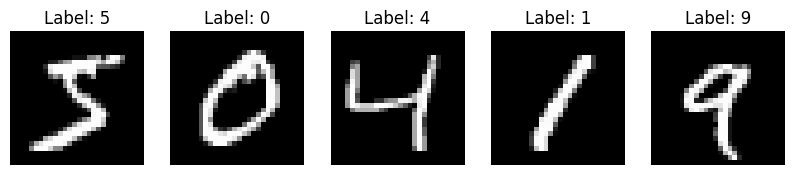

In [3]:
X = X.to_numpy()
y = y.to_numpy()
n_samples = X.shape[0]
image_size = (28, 28)
X_images = X.reshape(n_samples, 28,28)



def plot_sample_images(images, labels, num_samples=5):
    plt.figure(figsize=(10, 2))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
plot_sample_images(X_images, y, num_samples=5)

In [4]:
def get_training_data(X,Y,train_size):
    X_tra = X[:train_size]
    Y_tra = Y[:train_size]
    Y_tra = [[1 if j == int(i) else 0 for j in range(10)] for i in Y_tra]
    Y_tra = jnp.array(Y_tra)
    X_tra = jnp.reshape(jnp.array(X_tra),(train_size, 28,28))
    X_tra = jnp.expand_dims(X_tra,axis = 1)
    X_tra = X_tra.astype('float32')/255.
    return X_tra,Y_tra
X_tra, Y_tra = get_training_data(X,y,40000)

In [16]:
X_t = X[40000:40000+5000]
Y_t = y[40000:40000+5000]
Y_t = [[1 if j == int(i) else 0 for j in range(10)] for i in Y_t]
Y_t = jnp.array(Y_t)
X_t = jnp.reshape(jnp.array(X_t),(5000, 28,28))
X_t = jnp.expand_dims(X_t,axis = 1)
X_t = X_t.astype('float32')/255.

In [5]:
net = Net(
    [
        Conv2D(1,4,20, accumulate_grad_norm=True, accumulate_params=True),
        MaxPool2d(2,2),
        Flatten(),
        Linear(2880, 50, accumulate_grad_norm=True,accumulate_parameters=True),
        # PReLU(accumulate_grad_norm=True,accumulate_parameters=True),
        Linear(50, 50, accumulate_grad_norm=True,accumulate_parameters=True),
        Sigmoid(),
        Linear(50, 10,accumulate_grad_norm=True,accumulate_parameters=True),
        SoftMax()
    ],
    reproducibility_key=20
)

In [7]:
net_3 = Net(
    [
        Conv2D(1,4,20, accumulate_grad_norm=True, accumulate_params=True, initialization='xavier'),
        MaxPool2d(2,2),
        Flatten(),
        Linear(2880, 50, accumulate_grad_norm=True,accumulate_parameters=True,initialization='xavier'),
        Linear(50, 50, accumulate_grad_norm=True,accumulate_parameters=True,initialization='xavier'),
        Sigmoid(),
        Linear(50, 10,accumulate_grad_norm=True,accumulate_parameters=True,initialization='xavier'),
        SoftMax()
    ],
    reproducibility_key=20
)

In [8]:
net.reinitialize_layers()

In [9]:
def yield_batches(X, Y, batch_size):
    """
    Yields batches of data and labels of the specified batch size.
    
    Args:
        X (numpy.ndarray): Input data array of shape (n_samples, ...) where ... is the feature shape.
        Y (numpy.ndarray): Label array of shape (n_samples, ...).
        batch_size (int): Size of each batch.
    
    Yields:
        tuple: (batch_X, batch_Y) where each is a slice of X and Y of size batch_size
               (or smaller for the last batch if n_samples % batch_size != 0).
    """
    n_samples = X.shape[0]
    
    # Ensure X and Y have compatible shapes
    assert n_samples == Y.shape[0], "Number of samples in X and Y must match"
    
    # Iterate over the dataset in chunks of batch_size
    for start_idx in range(0, n_samples, batch_size):
        end_idx = min(start_idx + batch_size, n_samples)
        yield X[start_idx:end_idx], Y[start_idx:end_idx]

In [10]:
epochs = 10
batch_size = 100
crit = CCE()
optimizer = SGD(0.0001,net)

In [11]:
for epoch in range(epochs):
    epoch_loss = 0
    for X_train, Y_train in yield_batches(X_tra,Y_tra,batch_size):
        pred = net.forward(X_train)
        loss = crit.loss(pred,Y_train)
        ini_grad = crit.backward(loss)
        optimizer.step(ini_grad)
        epoch_loss += loss
    print(f"Loss for {epoch}/{epochs} -> {epoch_loss/1000}")

Loss for 0/10 -> 1.5021520853042603
Loss for 1/10 -> 0.8654956221580505
Loss for 2/10 -> 0.7594203352928162
Loss for 3/10 -> 0.6802504658699036
Loss for 4/10 -> 0.6265673637390137
Loss for 5/10 -> 0.5903760194778442
Loss for 6/10 -> 0.5600228905677795
Loss for 7/10 -> 0.5288215279579163
Loss for 8/10 -> 0.5083159804344177
Loss for 9/10 -> 0.48813870549201965


In [12]:
epochs = 10
batch_size = 100
crit = CCE()
optimizer = SGD(0.0001,net_2)

In [13]:
for epoch in range(epochs):
    epoch_loss = 0
    for X_train, Y_train in yield_batches(X_tra,Y_tra,batch_size):
        pred = net_2.forward(X_train)
        loss = crit.loss(pred,Y_train)
        ini_grad = crit.backward(loss)
        optimizer.step(ini_grad)
        epoch_loss += loss
    print(f"Loss for {epoch}/{epochs} -> {epoch_loss/1000}")

Loss for 0/10 -> 0.3976595401763916
Loss for 1/10 -> 0.20733965933322906
Loss for 2/10 -> 0.15206699073314667
Loss for 3/10 -> 0.12318722903728485
Loss for 4/10 -> 0.10504467040300369
Loss for 5/10 -> 0.09241606295108795
Loss for 6/10 -> 0.08302956819534302
Loss for 7/10 -> 0.07571803033351898
Loss for 8/10 -> 0.06981858611106873
Loss for 9/10 -> 0.06492830067873001


In [14]:
epochs = 10
batch_size = 100
crit = CCE()
optimizer = SGD(0.0001,net_3)

In [15]:
for epoch in range(epochs):
    epoch_loss = 0
    for X_train, Y_train in yield_batches(X_tra,Y_tra,batch_size):
        pred = net_3.forward(X_train)
        loss = crit.loss(pred,Y_train)
        ini_grad = crit.backward(loss)
        optimizer.step(ini_grad)
        epoch_loss += loss
    print(f"Loss for {epoch}/{epochs} -> {epoch_loss/1000}")

Loss for 0/10 -> 0.8749940991401672
Loss for 1/10 -> 0.6563830971717834
Loss for 2/10 -> 0.4573681652545929
Loss for 3/10 -> 0.35336121916770935
Loss for 4/10 -> 0.2944281995296478
Loss for 5/10 -> 0.2561711072921753
Loss for 6/10 -> 0.2288804054260254
Loss for 7/10 -> 0.20815864205360413
Loss for 8/10 -> 0.19186200201511383
Loss for 9/10 -> 0.17875604331493378


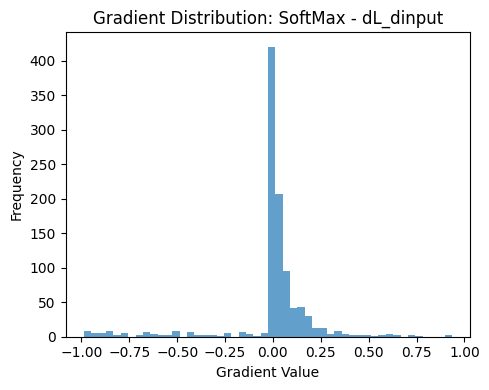

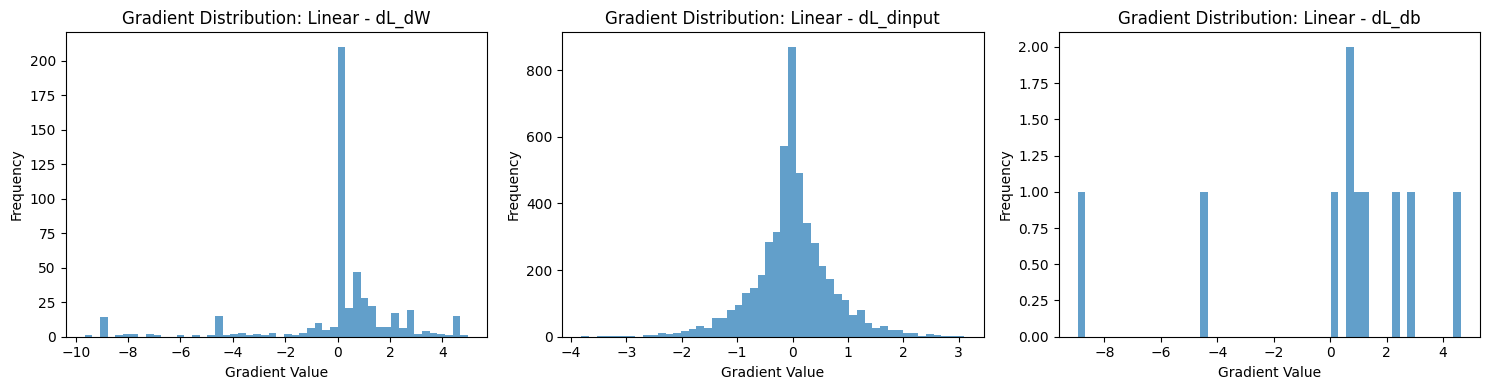

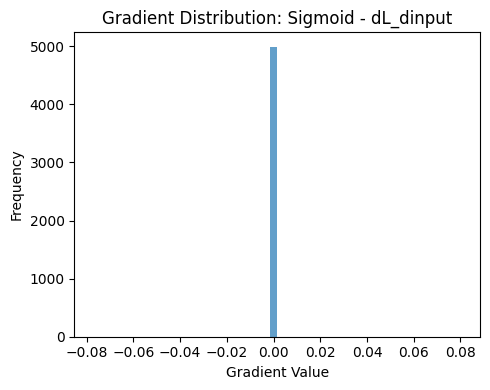

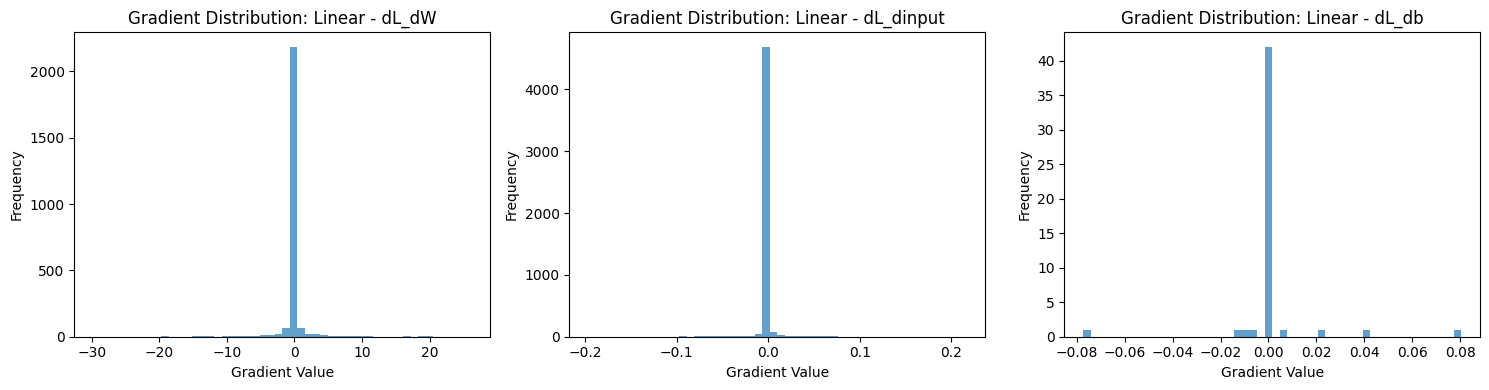

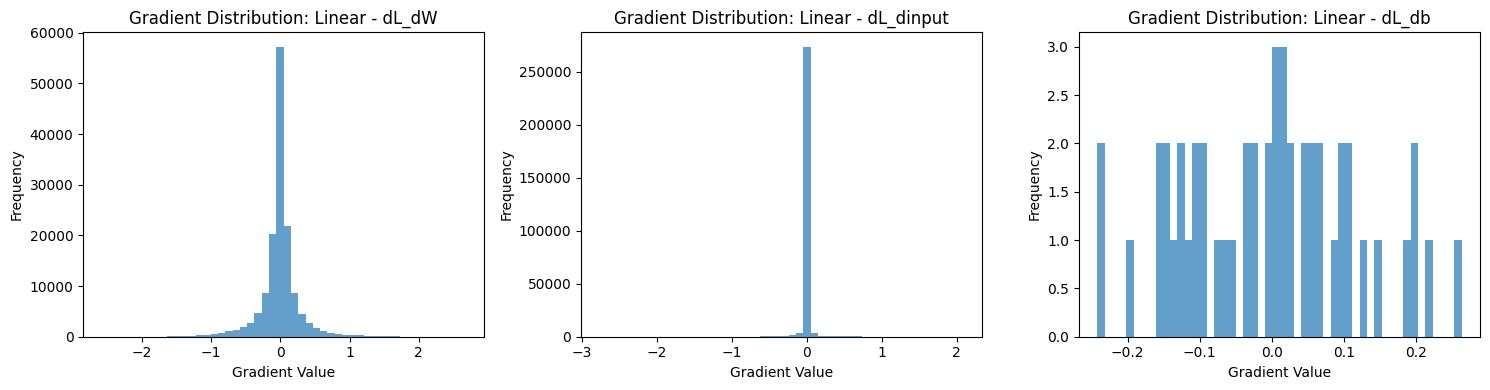

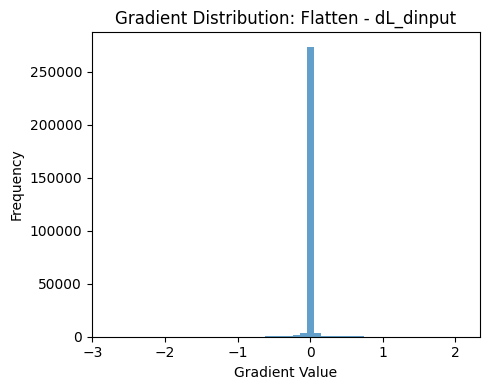

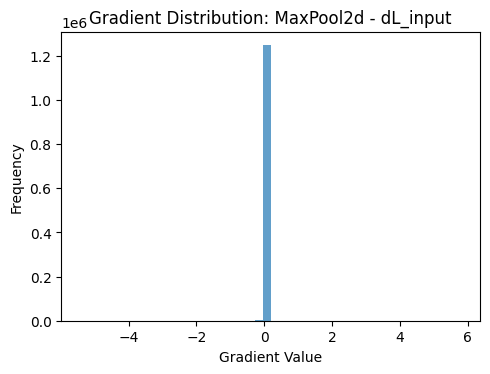

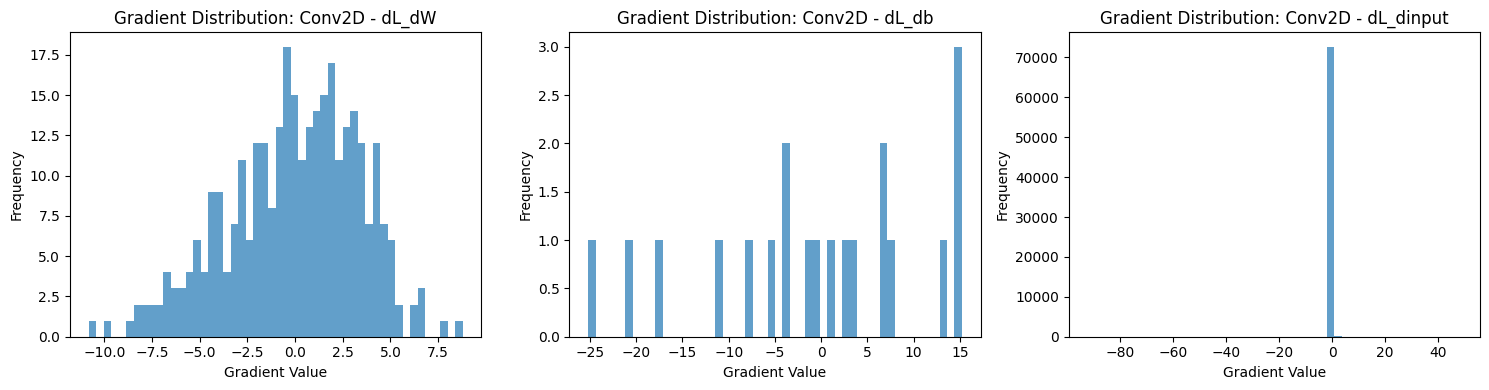

In [16]:
net.plot_backprop_grad_dist()

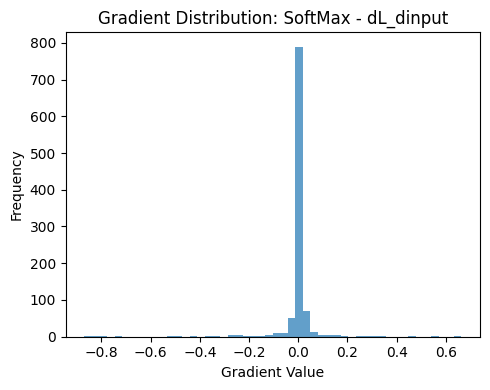

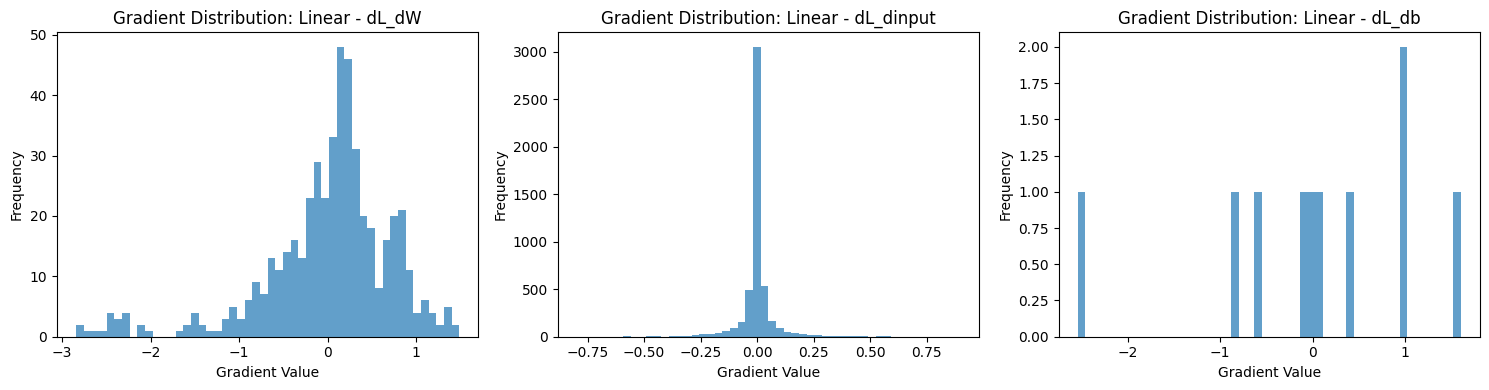

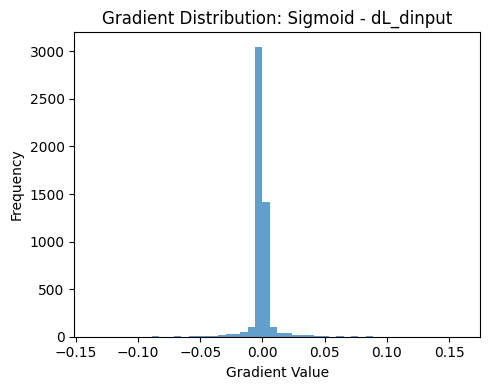

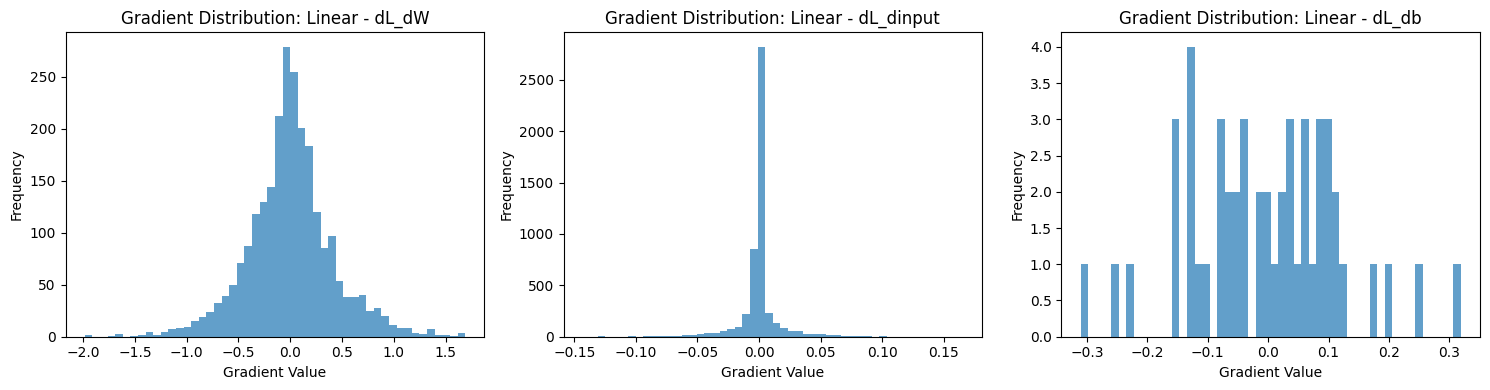

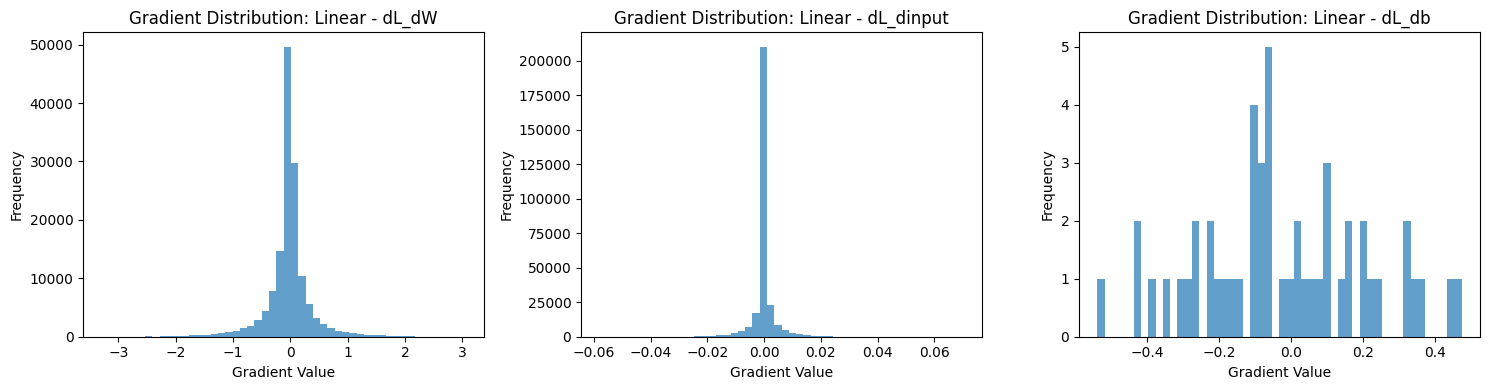

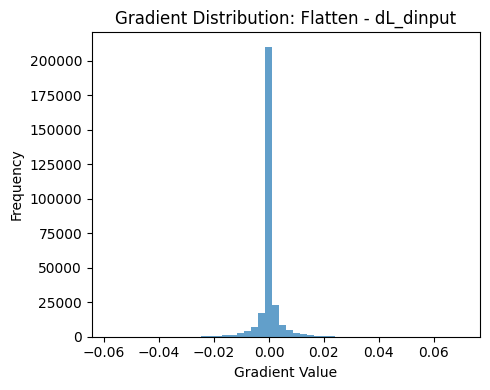

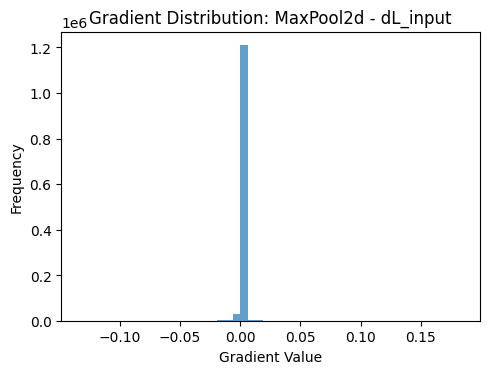

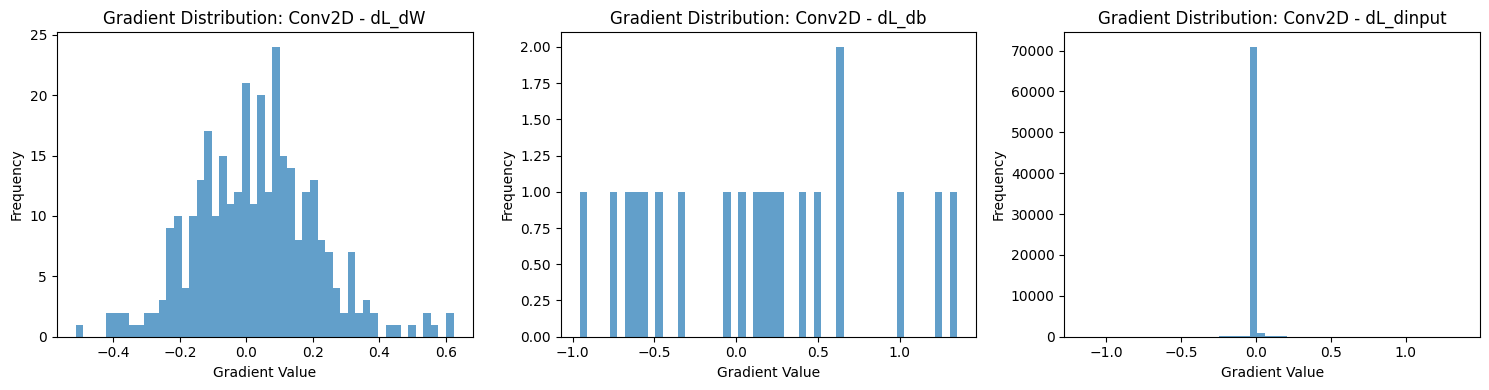

In [17]:
net_2.plot_backprop_grad_dist()

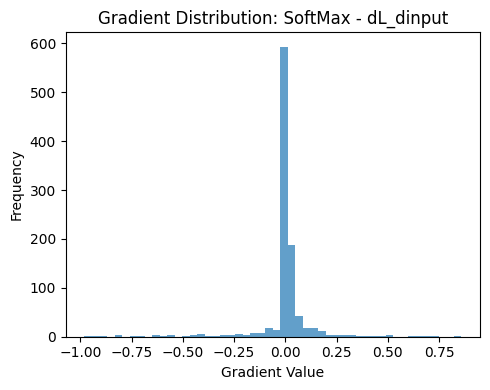

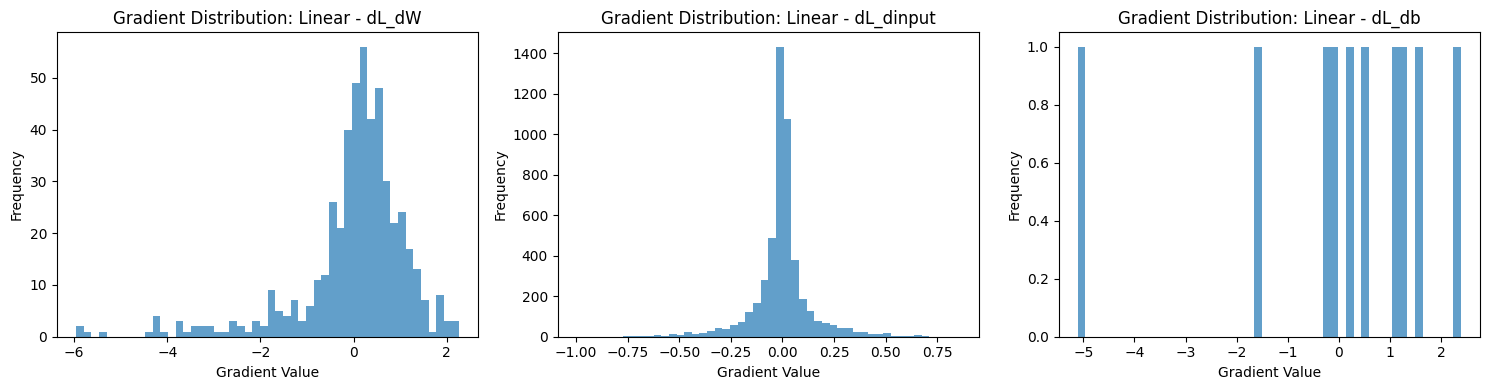

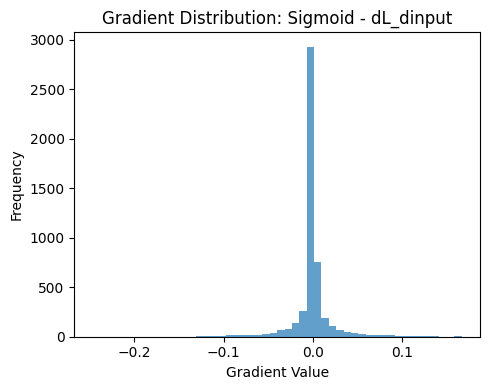

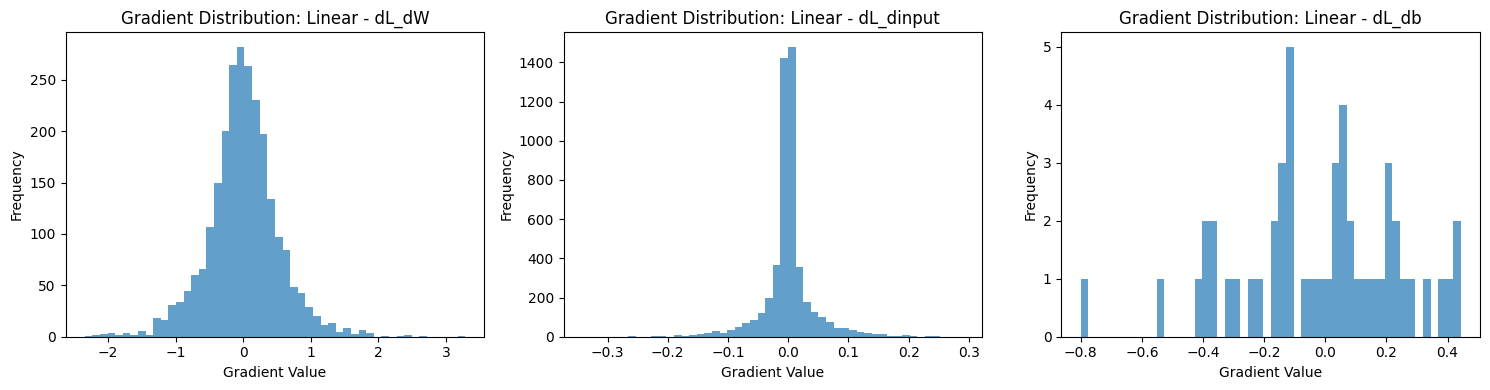

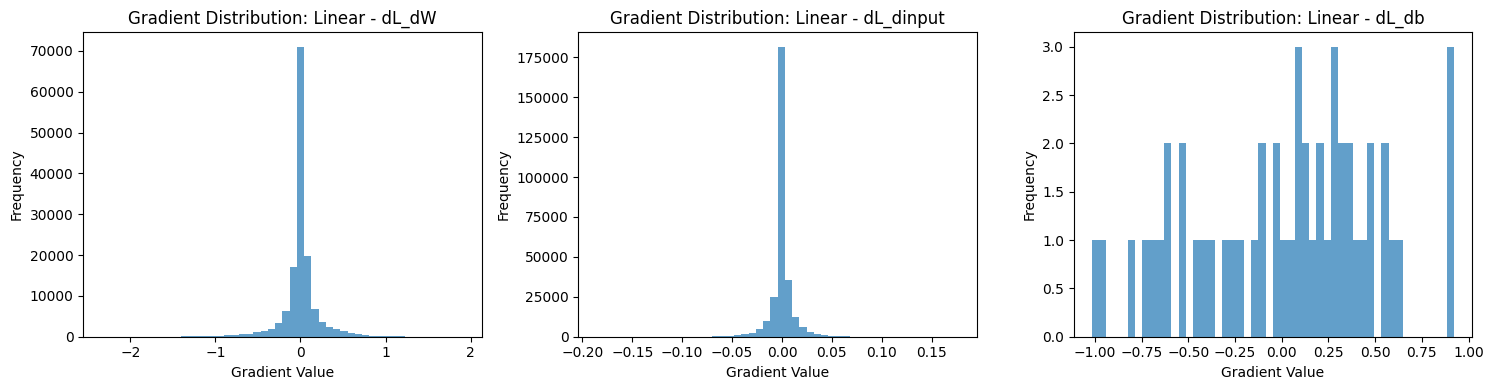

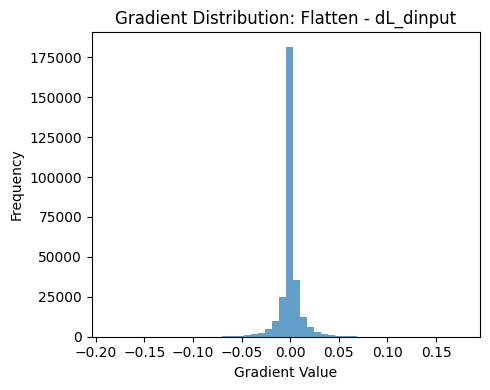

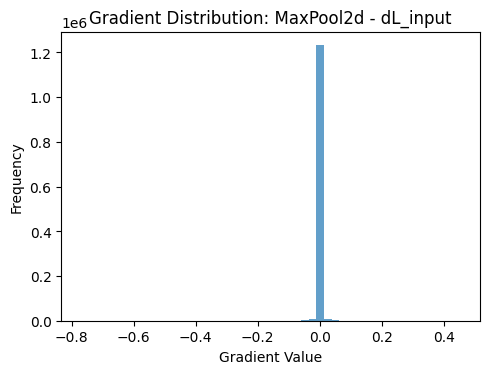

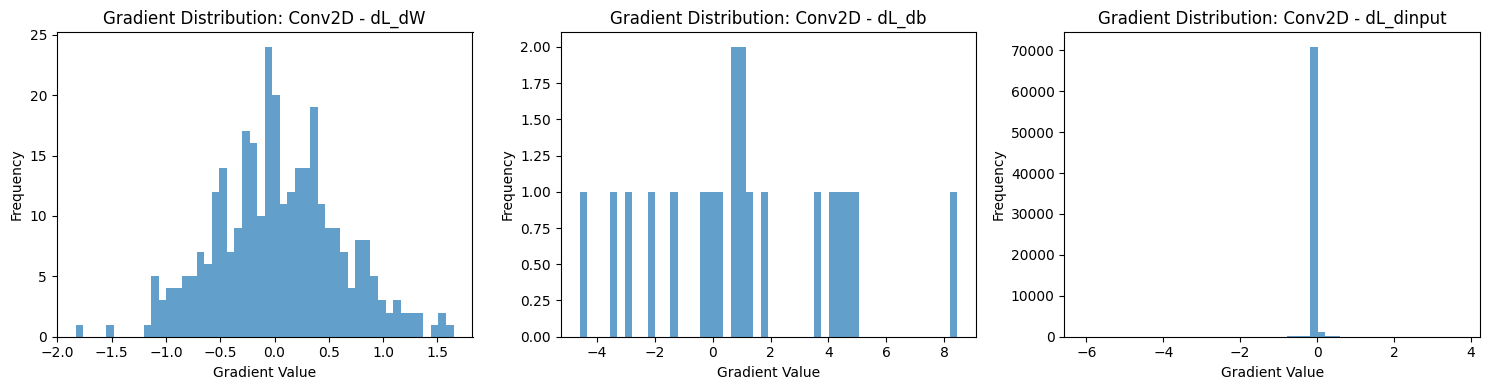

In [18]:
net_3.plot_backprop_grad_dist()

In [14]:
k,S,t = jnp.linalg.svd(net.layers[0].output.reshape(5,-1))

In [17]:
import numpy as np

In [19]:
S

XlaRuntimeError: FAILED_PRECONDITION: Buffer Definition Event: Error preparing computation: Out of memory allocating 15625000196 bytes.

In [77]:
net.layers[0].get_svd()

Singular values of Conv2D_layer Kernels -> [1.2072958  0.8480627  0.7438355  0.6146811  0.5370159  0.50599456
 0.4348601  0.39643046 0.37729785 0.25371704 0.19916183 0.16096161
 0.15572095 0.11628322 0.0872848  0.05416445]


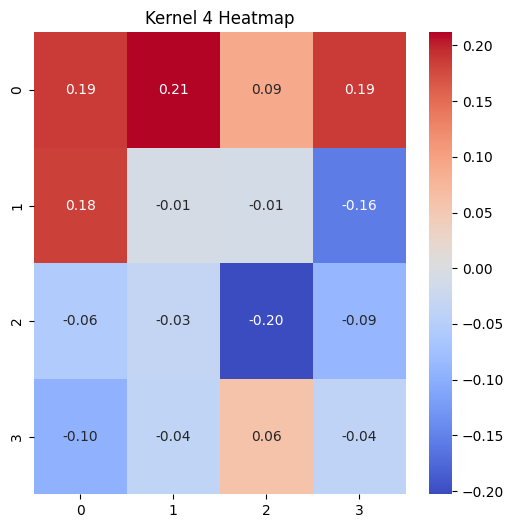

In [104]:
net.layers[0].plot_kernel(4)

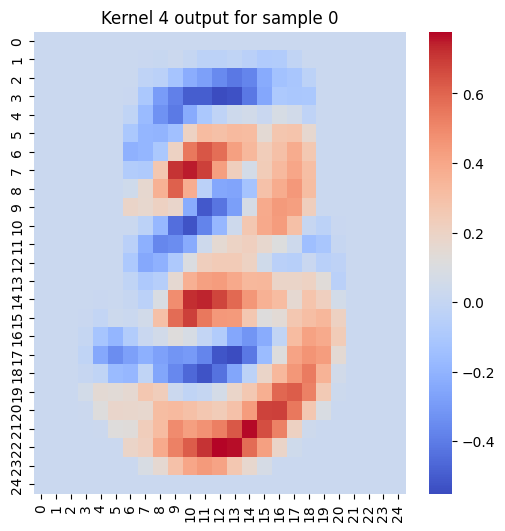

In [105]:
show_conv_out(net.layers[0],0,4)

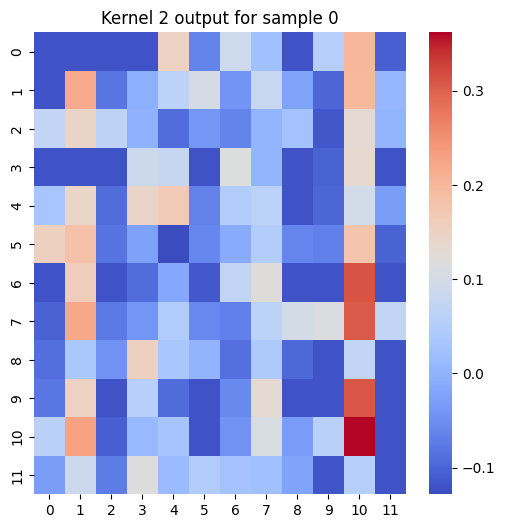

In [101]:
show_conv_out(net.layers[1],0,2)

In [17]:
res = net.forward(X_t)
loss = crit.loss(res,Y_t)
print(loss)

0.17137612


In [23]:
net.print_variance_info()

Linear 0
Weights Variance and Mean -> (Array(1.2042918, dtype=float32), Array(-0.01967998, dtype=float32))
Bias Variance and Mean -> (Array(0., dtype=float32), Array(0., dtype=float32))
Input Variance and Mean -> (Array(0.0919449, dtype=float32), Array(0.126595, dtype=float32))
Output Variance and Mean -> (Array(2.1836693, dtype=float32), Array(-0.04955678, dtype=float32))
Linear 3
Weights Variance and Mean -> (Array(1.0046912, dtype=float32), Array(-0.00155826, dtype=float32))
Bias Variance and Mean -> (Array(0., dtype=float32), Array(0., dtype=float32))
Input Variance and Mean -> (Array(2.3327687, dtype=float32), Array(0.5879611, dtype=float32))
Output Variance and Mean -> (Array(29116.602, dtype=float32), Array(-6.072758, dtype=float32))
Relu 4
Input Variance and Mean -> (Array(29116.602, dtype=float32), Array(-6.072758, dtype=float32))
Output Variance and Mean -> (Array(12477.077, dtype=float32), Array(46.308186, dtype=float32))
Linear 5
Weights Variance and Mean -> (Array(1.035388

In [9]:
net.print_variance_info()

Conv2D 0
Weights Variance and Mean -> (Array(0.01117783, dtype=float32), Array(-0.07683013, dtype=float32))
Bias Variance and Mean -> (Array(0.16920651, dtype=float32), Array(-0.45929724, dtype=float32))
Input Variance and Mean -> (Array(0.09613983, dtype=float32), Array(0.13251203, dtype=float32))
Output Variance and Mean -> (Array(0.46331933, dtype=float32), Array(-0.6628892, dtype=float32))
Linear 3
Weights Variance and Mean -> (Array(0.00148428, dtype=float32), Array(-0.00805826, dtype=float32))
Bias Variance and Mean -> (Array(0.00607282, dtype=float32), Array(0.00655353, dtype=float32))
Input Variance and Mean -> (Array(0.3458911, dtype=float32), Array(-0.5633386, dtype=float32))
Output Variance and Mean -> (Array(74770.83, dtype=float32), Array(98.24952, dtype=float32))
PReLU 4
Input Variance and Mean -> (Array(74770.83, dtype=float32), Array(98.24952, dtype=float32))
Output Variance and Mean -> (Array(302825.4, dtype=float32), Array(-97.10747, dtype=float32))
Linear 5
Weights V

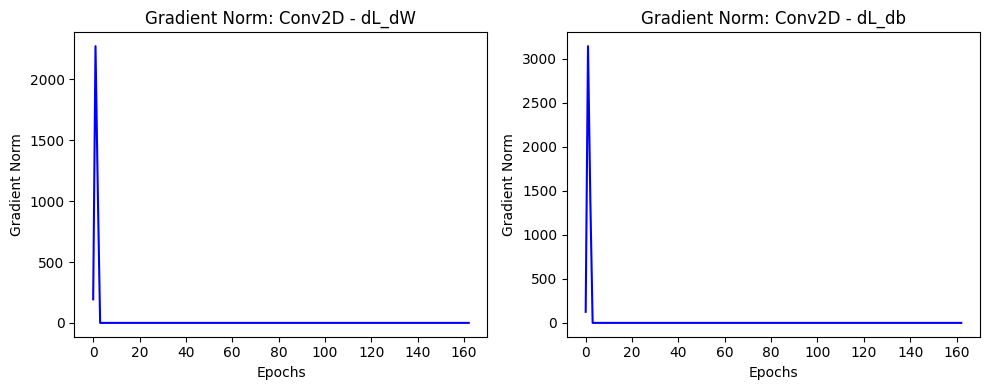

In [10]:
net.layers[0].plot_grad_norm()

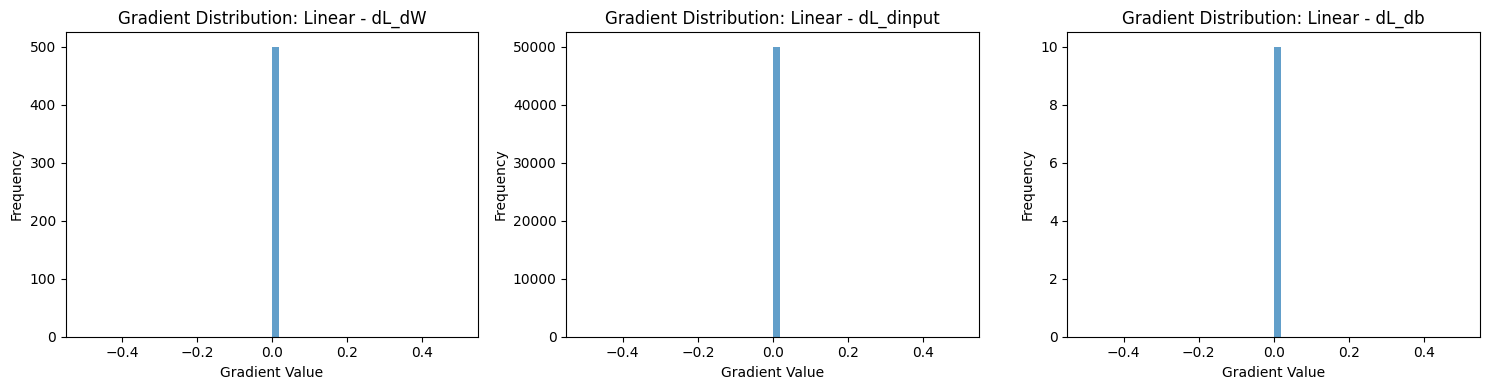

In [13]:
net.layers[5].plot_grad_dist()

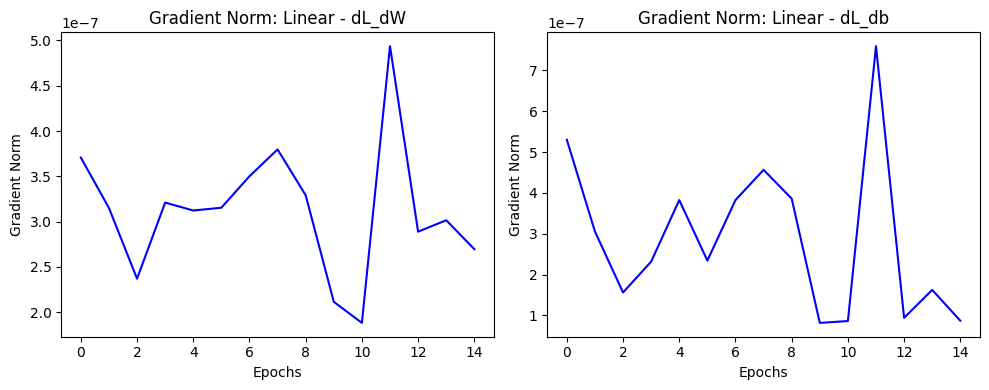

In [22]:
net.layers[-2].plot_grad_norm()

In [26]:
pred = net.forward(X_images)
loss = crit.loss(pred,Y)

In [27]:
ini_grad = crit.backward()

In [29]:
n_grad = net.layers[-1].backward(ini_grad)

In [31]:
n2_grad = net.layers[-2].backward(n_grad)

In [38]:
n3_grad = net.layers[-3].backward(n2_grad)

In [ ]:
n3_grad.

Array(0.0213101, dtype=float32)

In [47]:
float(net.layers[-2].grad_cache['dL_dW'].var())

0.30466559529304504

In [35]:
net.print_gradient_info()

In [36]:
net.layers[0].grad_cache

{}

In [ ]:
net.la

Array([[0.08994269, 0.06616123, 0.16419159, 0.10785104, 0.06971591,
        0.11118355, 0.09949122, 0.08941592, 0.11923791, 0.0828089 ]],      dtype=float32)

In [ ]:
net.layers[-1].backward(ini_grad)

SoftMax(requires_grad=False, _grad_norm={}, _accum_params={}, _accum_param_var_mean={}, grad_cache={'dL_dinput': Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)}, accumulate_grad_norm=False, accumulate_parameters=False)

In [15]:
ini_grad = crit.backward()

In [17]:
ini_grad

Array([[  0.      ,   0.      ,   0.      ,   0.      ,   0.      ,
        -10.351883,   0.      ,   0.      ,   0.      ,   0.      ]],      dtype=float32)

In [18]:
net.layers[-1].grad_cache

{'dL_dinput': Array([[2.6353767e-08, 2.5144498e-08, 2.5091239e-08, 2.4965079e-08,
         2.1306585e-08, 2.3031422e-08, 2.2559181e-08, 2.3867496e-08,
         2.1693191e-08, 2.4406114e-08]], dtype=float32)}

In [19]:
import jax.numpy as jnp
p = jnp.array([[0.0899, 0.0662, 0.1642, 0.1079, 0.0697, 0.1112, 0.0995, 0.0894, 0.1192, 0.0828]])
grad = jnp.array([[0, 0, 0, 0, 0, -10.351883, 0, 0, 0, 0]])
result = p * (grad - jnp.sum(p * grad, axis=1, keepdims=True))
print(result)

[[ 0.10348653  0.07620477  0.18901543  0.12420686  0.08023372 -1.0231237
   0.11453737  0.10291097  0.13721462  0.09531351]]


In [10]:
from MiniTorch.core.baseclasses import ComputationNode

In [ ]:
class Sigmoid(ComputationNode):

    def __init__(self):
        self.requires_grad = False

    def sigmoid(self,x):
        return 1/(1+jnp.exp(-x))
    def forward(self, x):
        self.input = x
        self.output = self.sigmoid(x)
        return self.output
    
    def backward(self, output_grad):
        self.grad_cache['dL_dinput'] = (self.output * (1 - self.output)) * output_grad
        return self.grad_cache['dL_dinput']
    
class Tanh(ComputationNode):

    def __init__(self):
        self.requires_grad = False

    def tanh(self,x):
        e_pos_x = jnp.exp(x)
        e_neg_x = jnp.exp(-x)
        numerator = e_pos_x - e_neg_x
        denominator = e_neg_x + e_pos_x
        tanh_res = numerator/denominator

    def forward(self, X):
        self.input = X
        self.output = self.tanh(X)
        return self.output
    
    def backward(self, output_grad):
        self.grad_cache['dL_dinput'] = (1 - jnp.power(self.output,2))*output_grad
        return self.grad_cache['dL_dinput']

class Dropout(ComputationNode):

    def __init__(self, p):
        super().__init__()
        self.p = p
        self.requires_grad = False
        self.mask = None
    def forward(self, x):
        if self.eval:
            return x
        self.input = x
        key = jax.random.PRNGKey(int(time.time()))
        mask = jax.random.bernoulli(key, self.p, x.shape).astype(jnp.float32)
        mask = mask / self.p
        self.mask = mask
        self.output = mask * x
        return self.output
    
    def backward(self, output_grad):
        self.grad_cache['dL_dinput'] = self.mask * output_grad
        return self.grad_cache['dL_dinput']


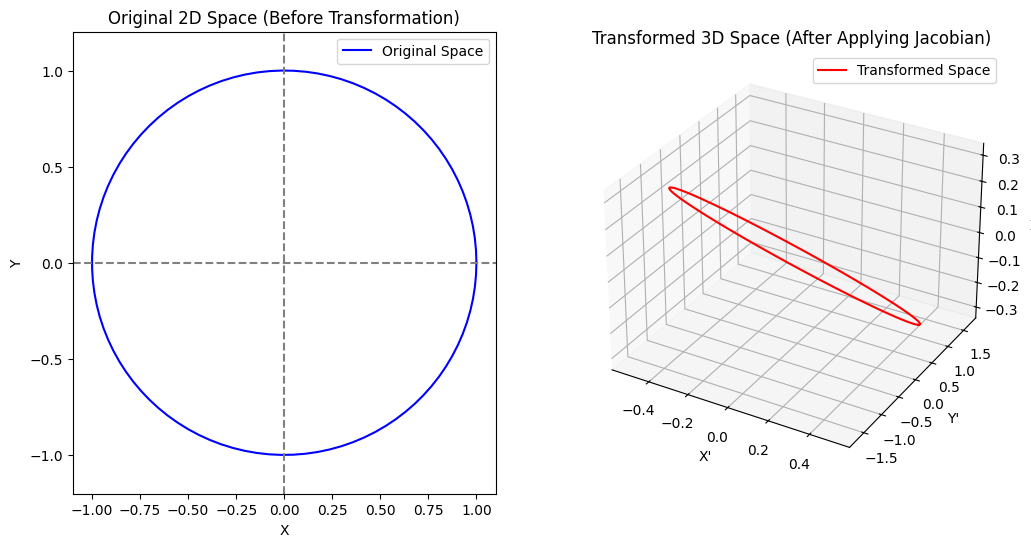

Singular Values of J: [1.68522445 0.52405039]


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Step 1: Generate 2D points in a unit circle
theta = np.linspace(0, 2 * np.pi, 100)
x = np.cos(theta)
y = np.sin(theta)
points_2d = np.vstack([x, y])  # Shape: (2, 100)

# Step 2: Define a random 2x3 transformation matrix (2D -> 3D)
np.random.seed(42)  # For reproducibility
J = np.random.randn(3, 2)  # Random Jacobian-like transformation

# Step 3: Apply transformation (2D -> 3D)
points_3d = J @ points_2d  # Shape: (3, 100)

# Step 4: Compute SVD to analyze stretching/squishing
U, S, Vt = np.linalg.svd(J)  # S contains singular values

# Step 5: Plot original 2D space
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)
ax1.plot(points_2d[0, :], points_2d[1, :], 'b', label="Original Space")
ax1.axhline(0, color='gray', linestyle='--')
ax1.axvline(0, color='gray', linestyle='--')
ax1.set_title("Original 2D Space (Before Transformation)")
ax1.set_xlabel("X")
ax1.set_ylabel("Y")
ax1.legend()
ax1.axis('equal')

# Step 6: Plot transformed 3D space
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot(points_3d[0, :], points_3d[1, :], points_3d[2, :], 'r', label="Transformed Space")
ax2.set_title(f"Transformed 3D Space (After Applying Jacobian)")
ax2.set_xlabel("X'")
ax2.set_ylabel("Y'")
ax2.set_zlabel("Z'")
ax2.legend()

plt.show()

# Step 7: Print singular values
print(f"Singular Values of J: {S}")

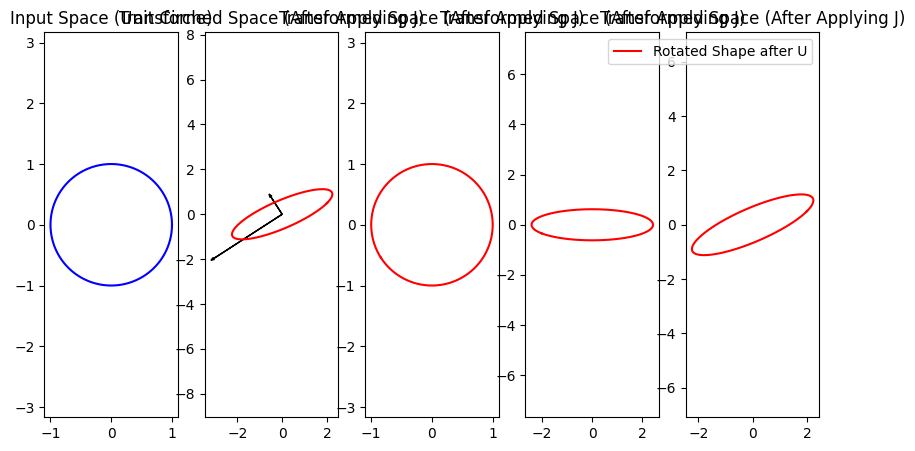

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate a 2D unit circle (100 points)
theta = np.linspace(0, 2 * np.pi, 100)
x = np.cos(theta)  # x-coordinates
y = np.sin(theta)  # y-coordinates
points_2d = np.vstack([x, y])  # Shape: (2, 100)

# Step 2: Define a transformation matrix J
J = np.array([[2, 1],  # This matrix stretches & rotates the space
              [0.5, 1]])

# Step 3: Apply the transformation
transformed_points = J @ points_2d  # Matrix multiplication (Shape: (2, 100))

# Step 4: Perform Singular Value Decomposition (SVD)
U, S, Vt = np.linalg.svd(J)

# Step 5: Visualize before and after transformation
fig, ax = plt.subplots(1, 5, figsize=(10, 5))

# Plot original space
ax[0].plot(points_2d[0], points_2d[1], 'b-', label='Original Circle')
ax[0].set_title("Input Space (Unit Circle)")
ax[0].axis("equal")

# Plot transformed space
ax[1].plot(transformed_points[0], transformed_points[1], 'r-', label='Transformed Shape')
ax[1].set_title("Transformed Space (After Applying J)")
ax[1].axis("equal")
rot_v1 = Vt @ points_2d
ax[2].plot(rot_v1[0], rot_v1[1], 'r-', label='Rotated Shape after V.T')
ax[2].set_title("Transformed Space (After Applying J)")
ax[2].axis("equal")
diag = np.diag(S)
stret = diag @ rot_v1
ax[3].plot(stret[0], stret[1], 'r-', label='Stretched Shape')
ax[3].set_title("Transformed Space (After Applying J)")
ax[3].axis("equal")
rot_v2 = U @ stret
ax[4].plot(rot_v2[0], rot_v2[1], 'r-', label='Rotated Shape after U')
ax[4].set_title("Transformed Space (After Applying J)")
ax[4].axis("equal")

# Step 6: Plot principal axes (right singular vectors)
for i in range(2):  # Two dimensions
    vec = Vt[i]  # Right singular vectors (Input space principal axes)
    scaled_vec = vec * S[i] * 1.5  # Scale for visualization
    ax[1].arrow(0, 0, scaled_vec[0], scaled_vec[1], head_width=0.1, color='k', label=f"Singular Vector {i+1}")

plt.legend()
plt.show()


In [5]:
S

array([2.42207845, 0.61930281])

In [18]:
rot = Vt @ points_2d

In [ ]:
np.expand_dims(S,axis=0) @ rot

array([[-2.37020722, -2.41586094, -2.45178684, -2.47784026, -2.4939163 ,
        -2.49995021, -2.49591771, -2.48183502, -2.45775886, -2.42378618,
        -2.38005376, -2.32673771, -2.26405271, -2.19225116, -2.11162219,
        -2.02249047, -1.92521489, -1.82018715, -1.70783015, -1.58859633,
        -1.46296579, -1.33144441, -1.19456177, -1.05286905, -0.9069368 ,
        -0.75735263, -0.60471887, -0.44965012, -0.29277079, -0.13471258,
         0.02388808,  0.18239254,  0.34016258,  0.4965629 ,  0.65096374,
         0.80274337,  0.95129065,  1.09600741,  1.23631093,  1.37163627,
         1.50143851,  1.62519499,  1.74240738,  1.85260372,  1.95534027,
         2.05020336,  2.136811  ,  2.21481446,  2.28389964,  2.34378836,
         2.39423948,  2.43504984,  2.46605511,  2.48713045,  2.49819099,
         2.4991922 ,  2.49013004,  2.47104101,  2.44200197,  2.40312985,
         2.35458117,  2.29655142,  2.22927428,  2.15302063,  2.06809753,
         1.97484693,  1.87364432,  1.7648972 ,  1.6

In [24]:
id = np.eye(2,2,dtype=float) 

In [38]:
S = np.diag(S)

In [41]:
stret = S @ rot

In [42]:
stret.shape

(2, 100)

In [44]:
U.shape

(2, 2)

Hessian Matrix:
 [[10  0]
 [ 0  1]]
Eigenvalues of Hessian: [10.  1.]


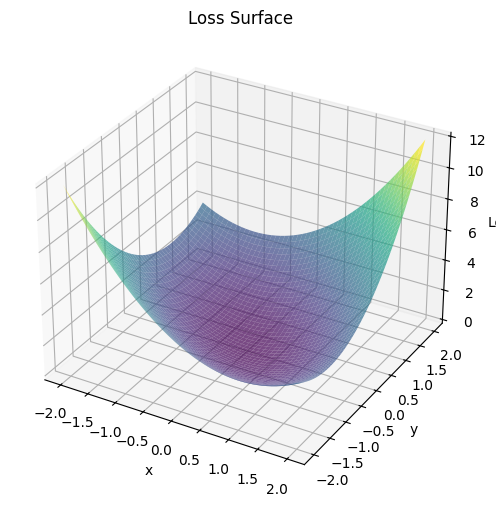

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Define a simple quadratic loss function
def loss_function(x, y):
    return x**2 + y**2 +x*y  # Different curvature in x and y

# Compute Hessian manually
H = np.array([[10, 0],  # Second derivative w.r.t x
              [0, 1]])   # Second derivative w.r.t y

# Compute eigenvalues
eigenvalues, eigenvectors = np.linalg.eig(H)

# Create a grid
x = np.linspace(-2, 2, 50)
y = np.linspace(-2, 2, 50)
X, Y = np.meshgrid(x, y)
Z = loss_function(X, Y)

# Plot the loss function surface
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("Loss")
ax.set_title("Loss Surface")

# Show eigenvalues
print("Hessian Matrix:\n", H)
print("Eigenvalues of Hessian:", eigenvalues)

plt.show()


In [18]:
def grad_loss_x(x,y):
    return 30*x*x + 20*y

def grad_loss_y(x,y):
    return 4*y

In [65]:
loss_function(1,1.8)

6.62

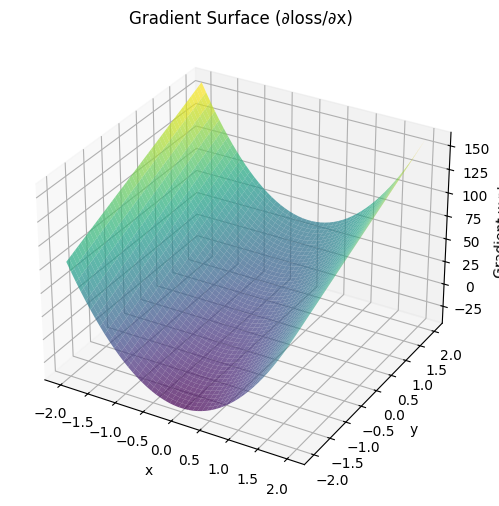

In [19]:
# Compute the gradient component
Z = grad_loss_x(X,Y)

# Plot the gradient surface
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("Gradient w.r.t. x")
ax.set_title("Gradient Surface (∂loss/∂x)")

plt.show()

In [ ]:
(grad_loss_x(0.03,0) - grad_loss_x(0,0))/0.01-0


0.3

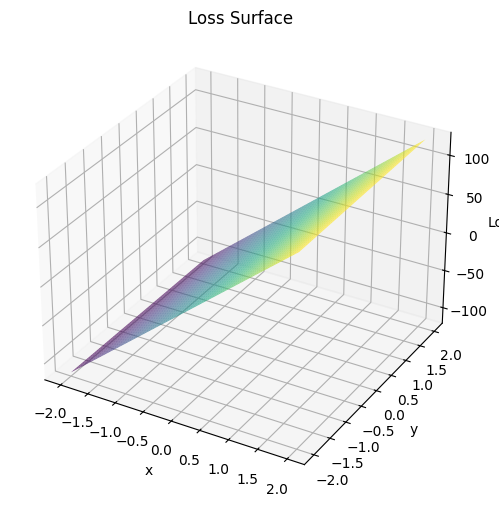

In [15]:
Z = 60 * X + 4

# Plot the loss function surface
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("Loss")
ax.set_title("Loss Surface")

plt.show()

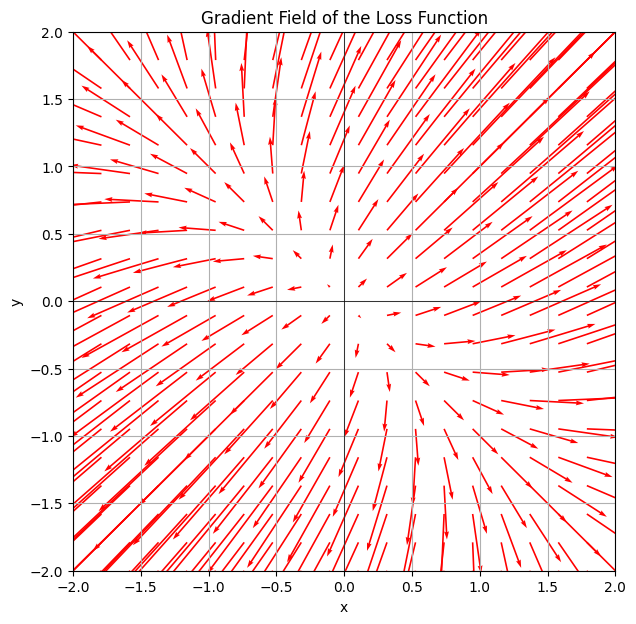

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# Define the loss function and its gradients
def grad_loss_x(x, y):
    return 2 * x + y

def grad_loss_y(x, y):
    return 2 *y + x

# Create a grid of (x, y) points
x = np.linspace(-2, 2, 20)
y = np.linspace(-2, 2, 20)
X, Y = np.meshgrid(x, y)

# Compute gradients
U = grad_loss_x(X, Y)  # Gradient in x direction
V = grad_loss_y(X, Y)  # Gradient in y direction

# Plot the vector field
plt.figure(figsize=(7, 7))
plt.quiver(X, Y, U, V, color='r', angles='xy', scale_units='xy', scale=5)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Gradient Field of the Loss Function")
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.grid()
plt.show()


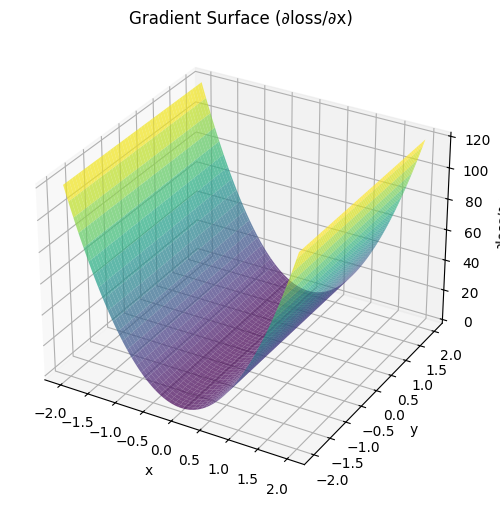

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Create meshgrid for X and Y
X = np.linspace(-2, 2, 100)
Y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(X, Y)

# Compute the gradient component ∂loss/∂x
Z = 30 * X**2

# Plot the gradient surface
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("∂loss/∂x")
ax.set_title("Gradient Surface (∂loss/∂x)")

plt.show()

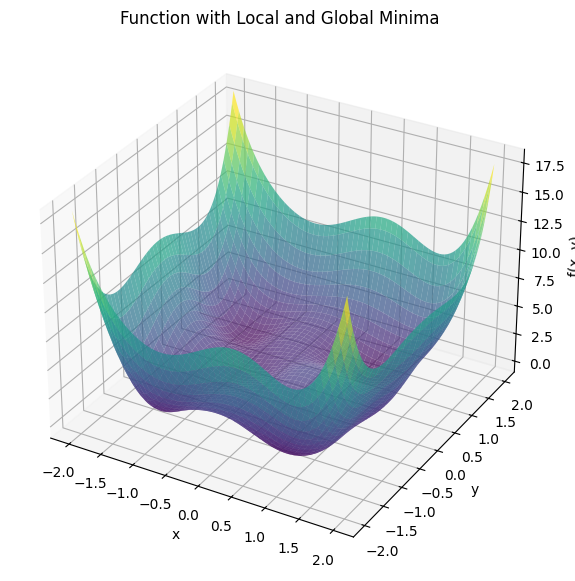

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the function
def f(x, y):
    return (x**2 - 1)**2 + (y**2 - 1)**2 + np.sin(3*x) * np.cos(3*y)

# Generate meshgrid
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

# Plot the surface
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)

# Labels and title
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("f(x, y)")
ax.set_title("Function with Local and Global Minima")

plt.show()


In [25]:
def f(x, y):
    return (x**2 - 1)**2 + (y**2 - 1)**2 + np.sin(3*x) * np.cos(3*y)

In [32]:
x1 = 2.01
x2 = 2
y = -0.62

grad = (f(x1,y) - f(x2,y))/(x1-x2)

In [29]:
np.sin(3*x1)

-0.25048898262707575

In [33]:
grad

23.39584842368275

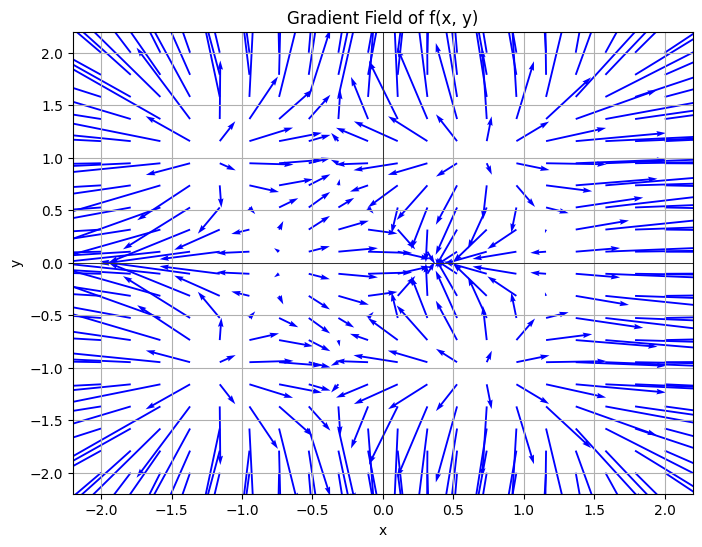

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function and its gradient
def f(x, y):
    return (x**2 - 1)**2 + (y**2 - 1)**2 + np.sin(3*x) * np.cos(3*y)

def grad_f(x, y):
    df_dx = 4*x*(x**2 - 1) + 3*np.cos(3*x) * np.cos(3*y)
    df_dy = 4*y*(y**2 - 1) - 3*np.sin(3*x) * np.sin(3*y)
    return df_dx, df_dy

# Generate grid
x = np.linspace(-2, 2, 20)
y = np.linspace(-2, 2, 20)
X, Y = np.meshgrid(x, y)

# Compute gradient at each point
U, V = grad_f(X, Y)

# Plot gradient field using quiver
plt.figure(figsize=(8,6))
plt.quiver(X, Y, U, V, color="b", angles='xy', scale_units='xy', scale=10)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Gradient Field of f(x, y)")
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid()
plt.show()


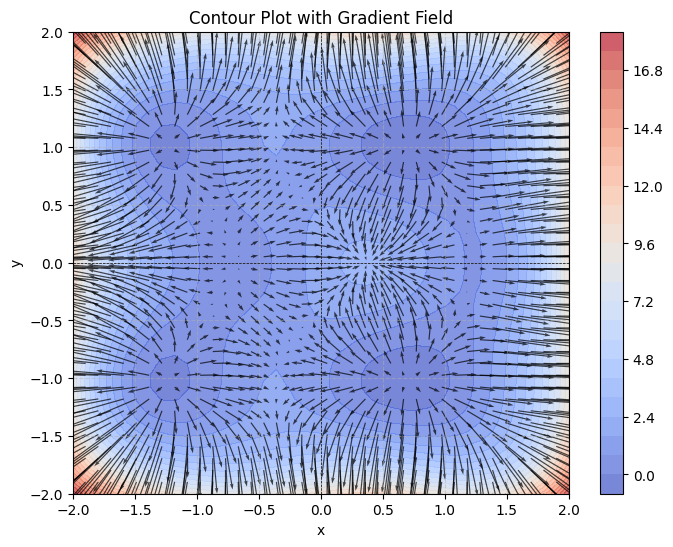

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def f(x, y):
    return (x**2 - 1)**2 + (y**2 - 1)**2 + np.sin(3*x) * np.cos(3*y)

# Define the gradient of f
def grad_f(x, y):
    df_dx = 4*x*(x**2 - 1) + 3*np.cos(3*x) * np.cos(3*y)
    df_dy = 4*y*(y**2 - 1) - 3*np.sin(3*x) * np.sin(3*y)
    return df_dx, df_dy

# Generate grid
x = np.linspace(-2, 2, 40)
y = np.linspace(-2, 2, 40)
X, Y = np.meshgrid(x, y)

# Compute function values
Z = f(X, Y)

# Compute gradient field
U, V = grad_f(X, Y)

# Plot contours
plt.figure(figsize=(8,6))
contour = plt.contourf(X, Y, Z, levels=30, cmap="coolwarm", alpha=0.7)  # Contour plot
plt.colorbar(contour)

# Overlay gradient field
plt.quiver(X, Y, U, V, color="black", angles='xy', scale_units='xy', scale=20, alpha=0.7)

# Labels and title
plt.xlabel("x")
plt.ylabel("y")
plt.title("Contour Plot with Gradient Field")
plt.axhline(0, color='black', linewidth=0.5, linestyle="--")
plt.axvline(0, color='black', linewidth=0.5, linestyle="--")
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()


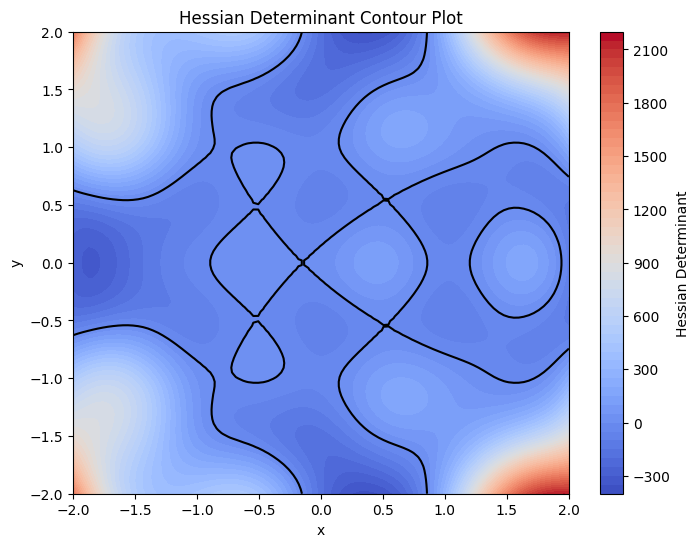

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, diff, lambdify, sin, cos

# Define variables
x, y = symbols('x y')

# Define the function using SymPy's sin and cos
f = (x**2 - 1)**2 + (y**2 - 1)**2 + sin(3*x) * cos(3*y)

# Compute second derivatives (Hessian matrix)
f_xx = diff(f, x, x)
f_yy = diff(f, y, y)
f_xy = diff(f, x, y)

# Compute Hessian determinant: D = (f_xx * f_yy) - (f_xy)^2
Hessian_det = (f_xx * f_yy) - (f_xy)**2

# Convert to numerical functions for plotting
f_xx_func = lambdify((x, y), f_xx, "numpy")
f_yy_func = lambdify((x, y), f_yy, "numpy")
f_xy_func = lambdify((x, y), f_xy, "numpy")
Hessian_func = lambdify((x, y), Hessian_det, "numpy")

# Create a grid
X, Y = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
D_vals = Hessian_func(X, Y)

# Plot Hessian determinant as a contour map
plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, D_vals, levels=50, cmap="coolwarm")
plt.colorbar(contour, label="Hessian Determinant")
plt.xlabel("x")
plt.ylabel("y")
plt.title("Hessian Determinant Contour Plot")

# Highlight potential saddle points (D < 0)
plt.contour(X, Y, D_vals, levels=[0], colors="black", linewidths=1.5)

plt.show()


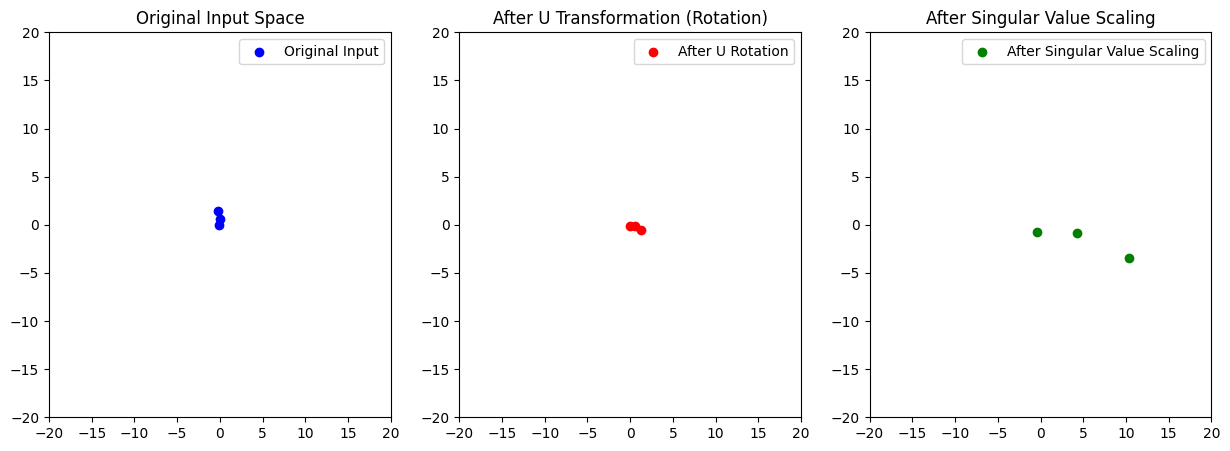

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Generate Input Matrix (3 samples, 2 features)
X = np.random.randn(3, 2)

# Step 2: Generate Random Weight Matrix (2 × 50)
W = np.random.randn(2, 50)

# Step 3: Perform SVD
U, S, Vt = np.linalg.svd(W, full_matrices=True)

# Step 4: Transformations
X_U = X @ U  # Transform input by U (rotation in input space)
X_US = X_U @ np.diag(S[:2])  # Apply singular values (scaling)

# Set axis limits for consistent visualization
x_min, x_max = min(X[:, 0].min(), X_U[:, 0].min(), X_US[:, 0].min()), max(X[:, 0].max(), X_U[:, 0].max(), X_US[:, 0].max())
y_min, y_max = min(X[:, 1].min(), X_U[:, 1].min(), X_US[:, 1].min()), max(X[:, 1].max(), X_U[:, 1].max(), X_US[:, 1].max())

# Visualization of Transformations
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot Input Space
axs[0].scatter(X[:, 0], X[:, 1], color='blue', label="Original Input")
axs[0].set_title("Original Input Space")
axs[0].set_xlim(-20, 20)
axs[0].set_ylim(-20, 20)
axs[0].legend()

# Plot After U Transformation
axs[1].scatter(X_U[:, 0], X_U[:, 1], color='red', label="After U Rotation")
axs[1].set_title("After U Transformation (Rotation)")
axs[1].set_xlim(-20, 20)
axs[1].set_ylim(-20, 20)
axs[1].legend()

# Plot After S Transformation (Scaling)
axs[2].scatter(X_US[:, 0], X_US[:, 1], color='green', label="After Singular Value Scaling")
axs[2].set_title("After Singular Value Scaling")
axs[2].set_xlim(-20, 20)
axs[2].set_ylim(-20, 20)
axs[2].legend()

plt.show()


In [67]:
np.dot(Vt[6],Vt[1])

1.100465205072787e-17

In [54]:
np.diag(S, -48)

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [8.0118859 , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 6.42892205, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [56]:
res = X @ U @ np.diag(S[:2]) @ Vt[:2,:]

In [57]:
res = X @ W

In [59]:
res

array([[-5.07915209e-01, -1.88465324e-01, -2.61133391e-01,
         7.57057825e-01, -2.71733240e-01, -1.84253289e-01,
        -5.68245507e-01, -1.67117651e-01, -1.51024979e-01,
         3.21523272e-01, -1.33642710e+00, -6.68362008e-01,
        -2.40618483e-01, -7.98529863e-01, -8.08293681e-01,
         7.28915319e-01, -3.38311420e-01,  4.33552759e-01,
        -2.70059485e-01,  8.30935556e-02, -1.88884964e+00,
         2.74448782e-01,  3.08136842e-01,  6.51585857e-01,
        -5.40557740e-01,  3.04004028e-01, -5.07401722e-01,
         3.51859974e-01, -2.68295246e-01, -1.19862933e-01,
        -5.34889984e-01, -5.46378074e-01, -1.08003572e+00,
        -5.71760844e-01,  2.54718643e-01, -1.65234644e-01,
         2.64664415e-01,  8.39408384e-02,  1.58265357e-01,
         1.11687984e-01,  5.38411401e-01,  5.23069274e-01,
         7.96806258e-01, -1.45282922e+00, -4.41743639e-01,
         2.63892696e-01, -9.60967912e-01,  7.29952098e-01,
        -6.70105207e-01,  4.10004256e-01],
       [-1.07

In [60]:
import numpy as np

def compute_energy_distribution(output, num_components=2):
    """
    Computes the percentage of energy retained in the first `num_components` dimensions
    of the output vector.

    Parameters:
    - output (numpy array): The transformed output of shape (N, D) where N is the batch size and D is the output dim.
    - num_components (int): The number of principal components to consider (default: 2).

    Returns:
    - energy_ratio (float): Percentage of total energy retained in the first `num_components` dimensions.
    """
    # Compute the squared energy for each dimension
    energy_per_dim = np.square(output)

    # Compute total energy
    total_energy = np.sum(energy_per_dim)

    # Compute energy in the first `num_components` dimensions
    retained_energy = np.sum(energy_per_dim[:, :num_components])

    # Compute the ratio of retained energy
    energy_ratio = (retained_energy / total_energy) * 100

    return energy_ratio

# Example usage
output = np.array([[-5.07915209e-01, -1.88465324e-01, -2.61133391e-01,
         7.57057825e-01, -2.71733240e-01, -1.84253289e-01,
        -5.68245507e-01, -1.67117651e-01, -1.51024979e-01,
         3.21523272e-01, -1.33642710e+00, -6.68362008e-01,
        -2.40618483e-01, -7.98529863e-01, -8.08293681e-01,
         7.28915319e-01, -3.38311420e-01,  4.33552759e-01,
        -2.70059485e-01,  8.30935556e-02, -1.88884964e+00,
         2.74448782e-01,  3.08136842e-01,  6.51585857e-01,
        -5.40557740e-01,  3.04004028e-01, -5.07401722e-01,
         3.51859974e-01, -2.68295246e-01, -1.19862933e-01,
        -5.34889984e-01, -5.46378074e-01, -1.08003572e+00,
        -5.71760844e-01,  2.54718643e-01, -1.65234644e-01,
         2.64664415e-01,  8.39408384e-02,  1.58265357e-01,
         1.11687984e-01,  5.38411401e-01,  5.23069274e-01,
         7.96806258e-01, -1.45282922e+00, -4.41743639e-01,
         2.63892696e-01, -9.60967912e-01,  7.29952098e-01,
        -6.70105207e-01,  4.10004256e-01]])  # Shape (1, 50)

energy_retained = compute_energy_distribution(output, num_components=2)
print(f"Energy retained in the first 2 components: {energy_retained:.2f}%")


Energy retained in the first 2 components: 1.55%
